In [70]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import sys

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.width', 1000)

In [7]:
sys.path.append('C:\\Users\\doniz\\Documents\\ChurnAnalysis-Telco\\src')

from visualizacao_churn import plot_freq_customer
from visualizacao_churn import plot_seg_churn_customer
from visualizacao_churn import plot_descr_customer

In [2]:
file_path = 'C:\\Users\\doniz\\Documents\\ChurnAnalysis-Telco\\data\\WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(file_path)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Usando errors='coerce' para converter valores não-numéricos em NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [4]:
# Dividindo os dados em features e target
X = df.drop('Churn', axis=1)  # Supondo que 'Churn' é a coluna alvo
y = df['Churn']

In [57]:
# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

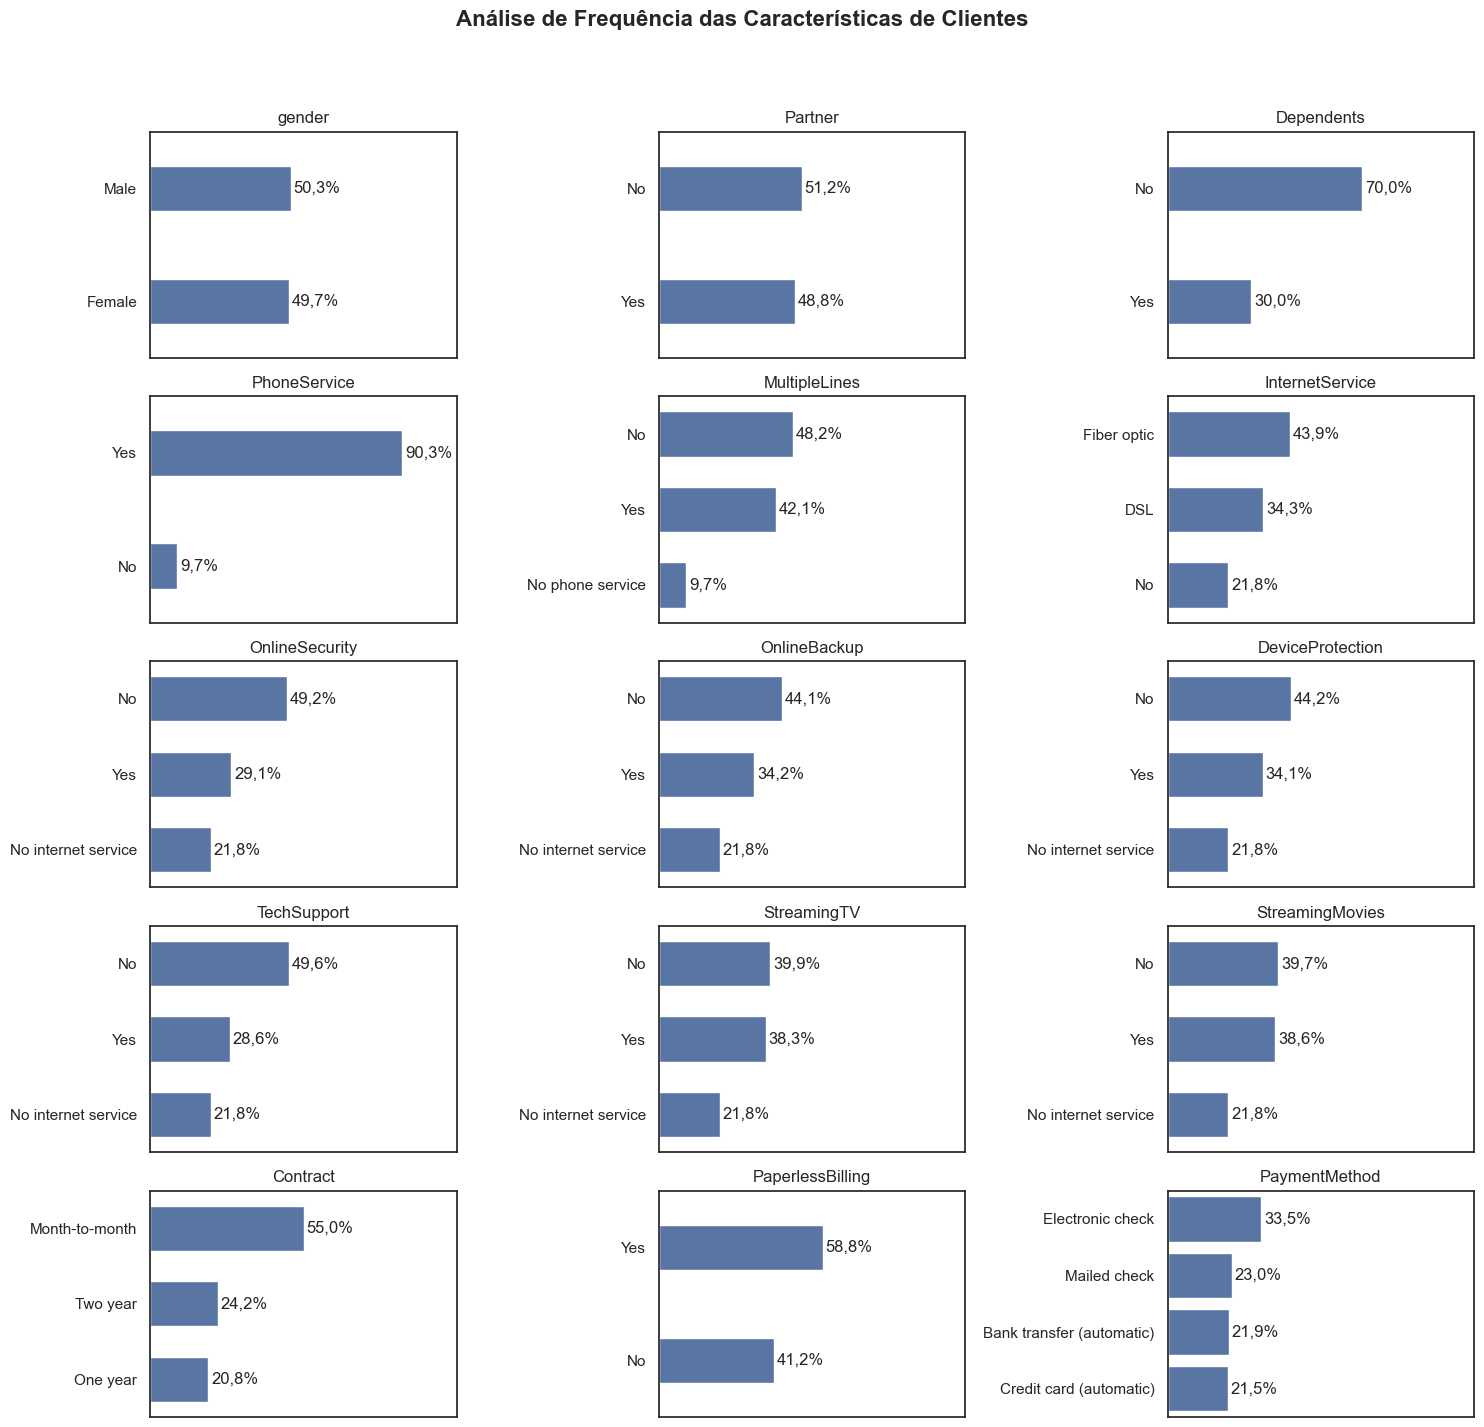

In [58]:
plot_freq_customer(X_train,3)

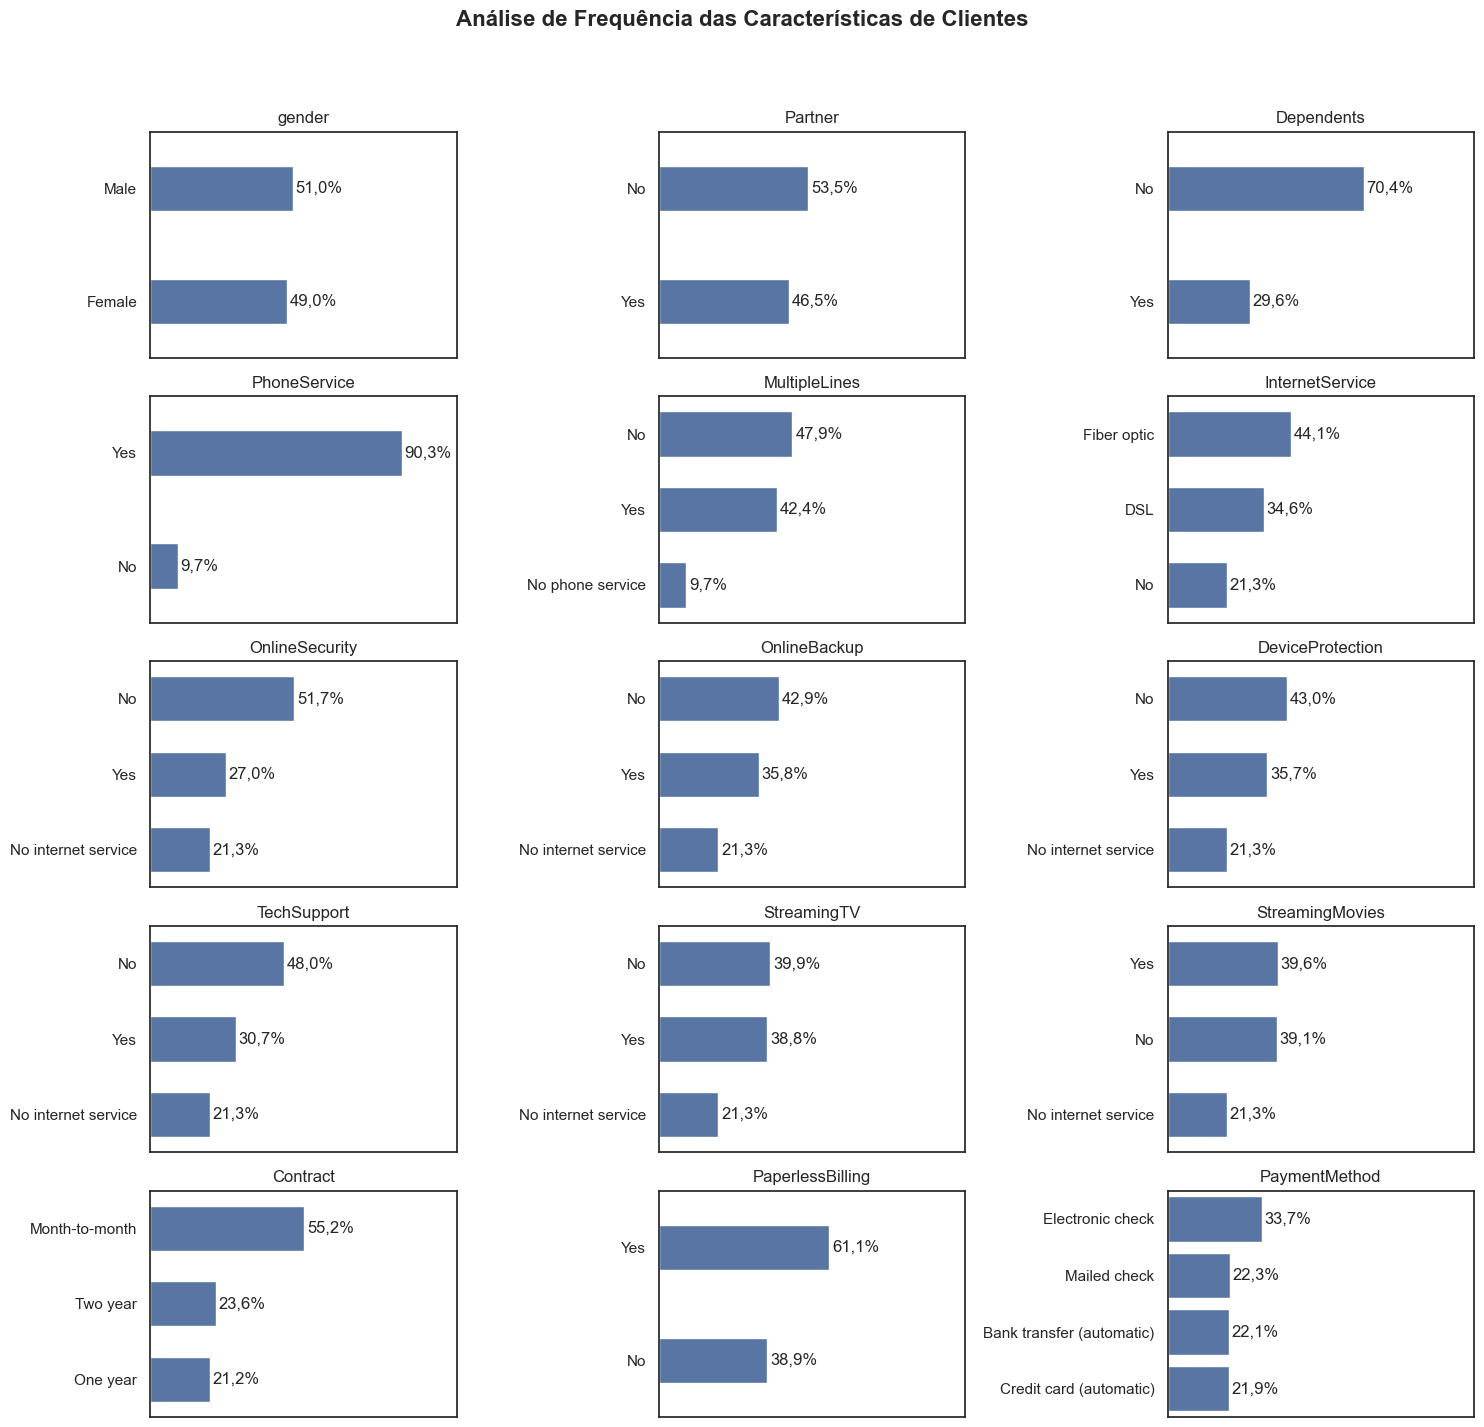

In [60]:
plot_freq_customer(X_test,3)

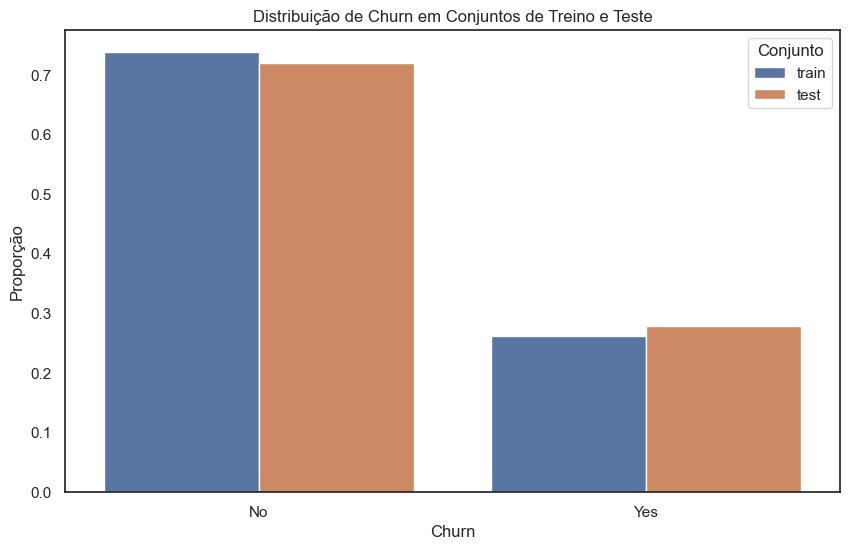

In [46]:
# Calculando as proporções de churn para o conjunto de treinamento e de teste
train_churn_prop = y_train.value_counts(normalize=True)
test_churn_prop = y_test.value_counts(normalize=True)

# Criando um DataFrame para visualização
prop_data = pd.DataFrame({'train': train_churn_prop, 'test': test_churn_prop})
prop_data.reset_index(inplace=True)
prop_data.rename(columns={'index': 'Churn'}, inplace=True)

# Criando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Churn', y='value', hue='variable', data=pd.melt(prop_data, id_vars='Churn'))
plt.title('Distribuição de Churn em Conjuntos de Treino e Teste')
plt.ylabel('Proporção')
plt.xlabel('Churn')
plt.legend(title='Conjunto')
plt.show()

In [62]:
y_train.reset_index(drop=True, inplace=True)

In [71]:
# Codificar os rótulos
encoder_y = LabelEncoder()
y_train_encoded = encoder_y.fit_transform(y_train)

In [61]:
X_train.reset_index(drop=True, inplace=True)

In [63]:
# Criar o encoder, opcionalmente usando drop='first' para evitar multicolinearidade
encoder = OneHotEncoder(drop='first')  # remove uma coluna para evitar multicolinearidade

In [82]:
X_train.dtypes == 'object'

customerID           True
gender               True
SeniorCitizen       False
Partner              True
Dependents           True
tenure              False
PhoneService         True
MultipleLines        True
InternetService      True
OnlineSecurity       True
OnlineBackup         True
DeviceProtection     True
TechSupport          True
StreamingTV          True
StreamingMovies      True
Contract             True
PaperlessBilling     True
PaymentMethod        True
MonthlyCharges      False
TotalCharges        False
dtype: bool

In [84]:
# Treinar o encoder no conjunto de teste (idealmente deveria ser no conjunto de treino)
category_column = X_train.dtypes[(X_train.dtypes == 'object')&(~X_train.dtypes.index.isin(['customerID','gender','PhoneService']))].index
encoder.fit(X_train[category_column])

OneHotEncoder(drop='first')

In [85]:
# Transformar a coluna categórica
encoded_features = encoder.transform(X_train[category_column]).toarray()
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

In [86]:
# Concatenar com o DataFrame original (removendo a coluna categórica original)
X_train_encoded = pd.concat([X_train.drop(category_column, axis=1), encoded_features_df], axis=1)

In [87]:
X_train_encoded.head()

,customerID,gender,SeniorCitizen,tenure,PhoneService,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,6457-GIRWB,Male,0,1,Yes,69.35,69.35,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
1,5115-GZDEL,Male,0,72,No,67.20,4671.70,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00
2,3398-ZOUAA,Male,1,21,Yes,69.10,1474.75,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
3,7011-CVEUC,Male,0,25,Yes,95.70,2338.35,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
4,3836-FZSDJ,Male,1,71,Yes,24.85,1901.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [88]:
# Configurando os modelos
models = {
    'RandomForest': RandomForestClassifier(random_state=123),
    'XGBoost': XGBClassifier(use_label_encoder=False, random_state=123),
    'LightGBM': LGBMClassifier(verbose=-1, random_state=123)
}

In [91]:
# Avaliação usando validação cruzada
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_encoded.drop(['customerID','gender','PhoneService'],axis=1), y_train_encoded, cv=10, scoring='accuracy')
    results[name] = scores
    print(f'{name}: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})')

RandomForest: 0.800 (+/- 0.011)
XGBoost: 0.786 (+/- 0.013)
LightGBM: 0.798 (+/- 0.015)


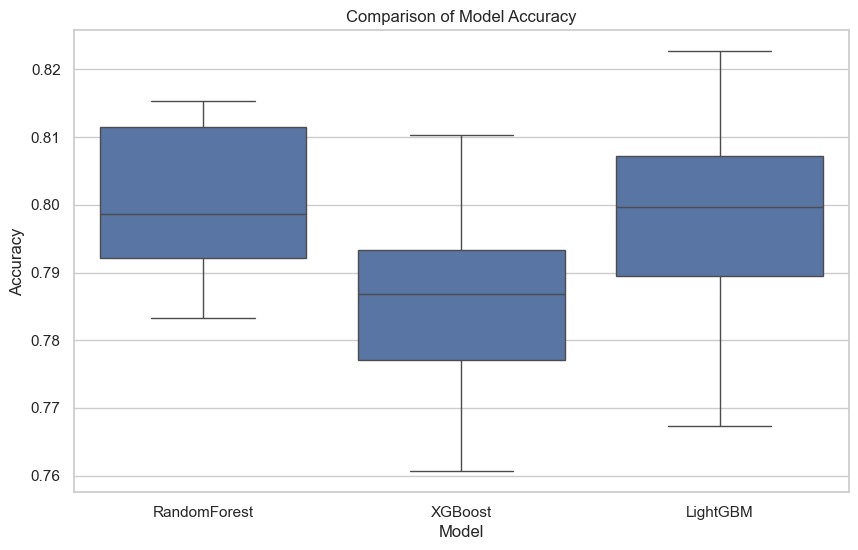

In [92]:

# Convertendo o dicionário em DataFrame para visualização
data = []
for model_name, scores in results.items():
    for score in scores:
        data.append({'Model': model_name, 'Accuracy': score})
df_scores = pd.DataFrame(data)

# Configurando o estilo do gráfico
sns.set(style="whitegrid")

# Criando o boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Model', y='Accuracy', data=df_scores)

# Adicionando títulos e rótulos
ax.set_title('Comparison of Model Accuracy')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

# Mostrando o gráfico
plt.show()
